In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.stats
import pickle
from sklearn.model_selection import ParameterGrid
from model import *
from msb import *

In [2]:
def proportion_DM(all_genotypes, pop):
    pa = np.sum([pop[i] for i in range(len(pop)) if (all_genotypes[i][0] == 2)])
    return(pa)

In [3]:
param_dict = {'s': [0.01, 0.03, 0.05], 'tau': [2,10,100], 'mu':[0.000004, 0.00004]}
param_grid = list(ParameterGrid(param_dict))
noise_levels = np.logspace(-6, np.log10(0.5), 30)

genotype_names_3 = []
for i in range(3):
    for j in range(2):
        for k in range(5):
            genotype_names_3.append((i,j,k))

In [6]:
msb_pop_sim = msb_simulation(genotype_names_3, 'MSB', 0.03, -1, 4e-5, 100, 2e-3, 2e-3)
mu, tau, s = 4e-5,100,0.03

In [11]:
nreps = 5000
pop_size = float(1e9)
ncat = len(genotype_names_3)

result_per_noise = []
print_p = True

nfixated = []
nextinct = []
times_fixated = []
times_extinct = []

noise = 0

for H in list(np.arange(2,10,0.2)):
    
    print(H)
    
    extinct = 0
    fixation = 0
    time_extinction = []
    time_fixation = []
    
    transition_matrix = mutation_rate_transition_V(mu, tau, 5, 2e-3, 2e-3, beta = 5000)
    proba_mut_dm = (tau * msb_pop_sim['pm']) / (1+tau * msb_pop_sim['pm'])

    fitness_vector = fitness(genotype_names_3, s, H, 'V', strain_fitness_vect = [1,1-s,1+s*H])
    msb_pop = msb_pop_sim['pop']
    
    results = np.zeros((nreps, ncat))

    for rep in range(nreps):
        results[rep] = np.random.multinomial(pop_size, msb_pop)
        mut_or_baseline = np.random.binomial(1, proba_mut_dm)
        results[rep,[20,25][mut_or_baseline]] = 1.

    results /= np.sum(results, axis = 1, keepdims = 1)

    t = 0
    update = (np.array([proportion_DM(genotype_names_3, results[i]) == 1. or proportion_DM(genotype_names_3, results[i]) == 0. for i in range(nreps)]))
    
    while (~update).any():

        t += 1

        results = results @ transition_matrix
        results *= fitness_vector

        results /= np.sum(results, axis = 1, keepdims = True)


        for rep in np.arange(nreps)[~update]:
                                
            results[rep] = np.random.multinomial(pop_size, results[rep])
            
            
            if proportion_DM(genotype_names_3, results[rep]) / np.sum(results[rep]) ==  0.:
                extinct += 1.
                time_extinction.append(t)
                update[rep] = True
            elif proportion_DM(genotype_names_3, results[rep]) / np.sum(results[rep]) == 1.:
                fixation += 1.
                time_fixation.append(t)
                update[rep] = True
                
    nfixated.append(fixation)
    nextinct.append(extinct)
    times_fixated.append(time_fixation)
    times_extinct.append(time_extinction)

2.0
2.2
2.4000000000000004
2.6000000000000005
2.8000000000000007
3.000000000000001
3.200000000000001
3.4000000000000012
3.6000000000000014
3.8000000000000016
4.000000000000002
4.200000000000002
4.400000000000002
4.600000000000002
4.8000000000000025
5.000000000000003
5.200000000000003
5.400000000000003
5.600000000000003
5.800000000000003
6.0000000000000036
6.200000000000004
6.400000000000004
6.600000000000004
6.800000000000004
7.000000000000004
7.200000000000005
7.400000000000005
7.600000000000005
7.800000000000005
8.000000000000005
8.200000000000006
8.400000000000006
8.600000000000005
8.800000000000006
9.000000000000007
9.200000000000006
9.400000000000006
9.600000000000007
9.800000000000008


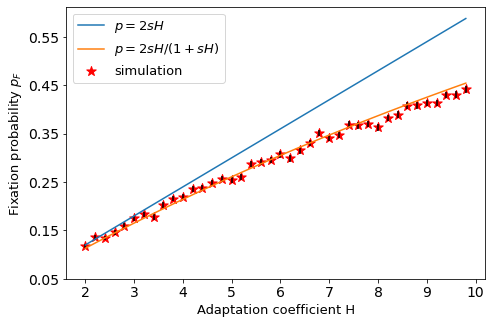

In [15]:
error_bars = np.sqrt(((np.array(nfixated)/5000) * (1-np.array(nfixated)/5000)) / 5000)

plt.subplots(1,1,figsize = (7.5,5))

plt.plot(list(np.arange(2,10,0.2)), [(2*0.03*h) for h in list(np.arange(2,10,0.2))])
plt.plot(list(np.arange(2,10,0.2)), [(2*0.03*h) / (1+0.03*h) for h in list(np.arange(2,10,0.2))])
plt.scatter(list(np.arange(2,10,0.2)), np.array(nfixated)/5000, c = 'red', marker = '*', s = 100.)
plt.errorbar(list(np.arange(2,10,0.2)), np.array(nfixated)/5000, yerr=error_bars, c = 'k', ls = '')
plt.ylabel('Fixation probability $p_F$', fontsize = 13)
plt.xlabel('Adaptation coefficient H', fontsize = 13)
plt.xticks(list(np.arange(2,11,1)), list(np.round(np.arange(2,11,1), 1)), fontsize = 14)
plt.yticks(list(np.arange(0.05,0.65,0.1)), list(np.round(np.arange(0.05,0.65,0.1), 2)), fontsize = 14)
plt.legend(['$p = 2sH$', '$p = 2sH / (1+sH)$', 'simulation'], fontsize = 13)
#plt.title('Comparison of fixation rate with simulated results')
plt.savefig('Fixation_DM.jpg', dpi = 400)